In [18]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [19]:
transform = transforms.ToTensor() # definindo a convesão de imagem para tensor

trainset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform) # Carrega a parte de treino do dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) # Cria um fuffer para pegar os dados por partes

valset = datasets.MNIST('./MNIST_data/', download=True, train=False,transform=transform) # Carrega a parte de validação do dataset
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True) # Cria um buffer para pegar os dados por partes


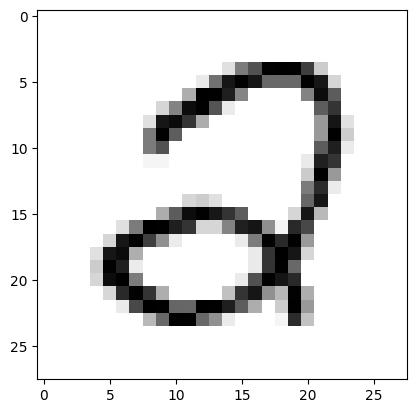

In [27]:
dataiter = iter(trainloader)
imagens, etiquetas = next(dataiter)
plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r')

In [21]:
print(imagens[0].shape) # Para verificar as dimensões do tensor de cada imagem
print(etiquetas[0].shape) # Para verificar as dimensões do tensor de cada etiqueta

torch.Size([1, 28, 28])
torch.Size([])


In [22]:
# Define a rede neural
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.fc1 = nn.Linear(28*28, 128) # camada de entrada, 784 neurônios que se ligam a 128
        self.fc2 = nn.Linear(128, 64) # camada interna 1, 128 neurônios que se ligal a 64
        self.fc3 = nn.Linear(64, 10) # camada interna 2, 64 neurônios que se ligal a 10
        # para a camada de saída não é necessário definir nada pois só precisamos pegar o output da camada interna 2


    def forward(self, x):
        x = F.relu(self.linear1(x)) # função de ativação da camada de entrada para a camada interna 1
        x = F.relu(self.linear2(x)) # função de ativação da camada de interna 1 para a camada interna 2
        x = F.relu(self.linear3(x)) # função de ativação da camada de interna 2 para a camada de saída, nesse caso f(x) = x

        return  F.log_softmax(x, dim=1) # dados utilizados para calcular a perda




In [23]:
def treino(modelo, trainloader, device):

  otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.05) # define a política de atualização dos pesos e da bias
  inicio = time() # timer para sabermos o tempo que lebou o treino

  criterio = nn.NLLLoss() # definindo o criterio para calcular a perda
  EPOCHS = 10 # numero de epochs que o algoritmo rodará / um bom treinamento é no minimo 100 epochs
  modelo.train() # ativando o mode de treinamento do modelo

  for epoch in range(EPOCHS):
    perda_acumulada = 0 # inicializaão de perda acumulada da epoch em questão

    for imagens, etiquetas in trainloader:

      imagens = imagens.view(imagens.shape[0], -1) # convertendo as imagens para "vetores" de 28*28 casas para ficarem compatíveus com a
      otimizador.zero_grad() # zerando os gradientes por conta do ciclo anterior

      output = modelo(imagens.to(device)) # zerando os gradientets por conta do cuclo anterior
      perda_instantanea = criterio(output, etiquetas.to(device)) # calculando a perda da epoch em questão

      perda_instantanea.backward() # back propagation a partir da perda

      otimizador.step() # atualizando os pesos e bias


      perda_acumudala += perda_instantanea.item() # atualizando a perda acumulada

    else:
      print("Epoch {} - Perda resultante: {}".format(epoch+1, perda_acumulada/len(trainloader)))

  print("\nTempo de treino (em minutos) =",(time()-inicio)/60)


In [24]:
def validacao(modelo, valloader, device):
  conta_corretas, conta_todas = 0, 0
  for imagens, etiquetas in valloader:
    for i in range(len(etiquetas)):
      img = imagens[i].view(1, 784)
      #desativar o autograd para acelevar a validação. Grafos computacionais dinâmicos tem um custo alto de processamento
      with torch.no_grad():
        logps = modelo(img.to(device)) # output do modelo em escala logaritmica


      ps = torch.exp(logps) # converte output para escala normal (lembrando que é um tensor)
      probab = list(ps.cpu().numpy()[0])
      etiqueta_pred = probab.index(max(probab)) # converte tensor em um número, no caso, o nímero que o modelo previu como correto
      etiqueta_certa = etiquetas.numpy([i])
      if (etiqueta_certa == etiqueta_pred): # compara a previsão com o valor correto
        conta_corretas +=1
      conta_todas += 1

    print("Total de imagens testadas =", conta_todas)
    print("\nPrevisão do modelo = {}".format(conta_corretas*100/conta_todas))

In [25]:
modelo = Modelo() # inicializa o modelo

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # modelo rodará no GPU se possível
modelo.to(device)

Modelo(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)